In [ ]:
# download data: https://drive.google.com/file/d/11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-/view?usp=share_link

# Use Pretrained Weight for Initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
PATH = 'flower_photos/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 256
IMG_SIZE = (160, 160)
BUFFER_SIZE = BATCH_SIZE*5

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                              PATH,
                                              validation_split=0.2,
                                              subset="training",
                                              seed=123,
                                              image_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [3]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                  PATH,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=123,
                                                  image_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


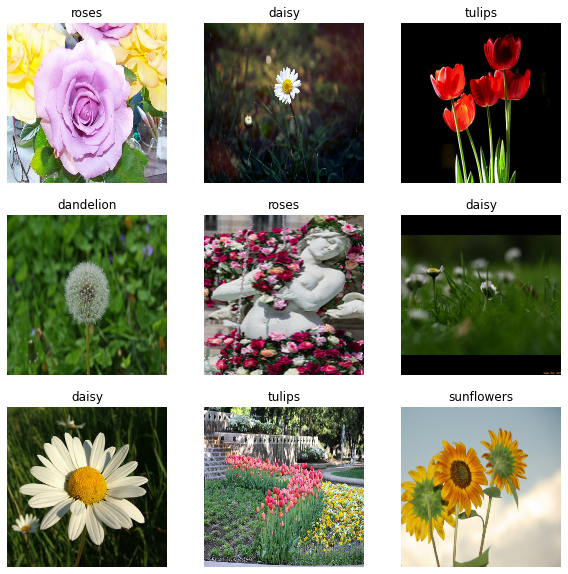

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

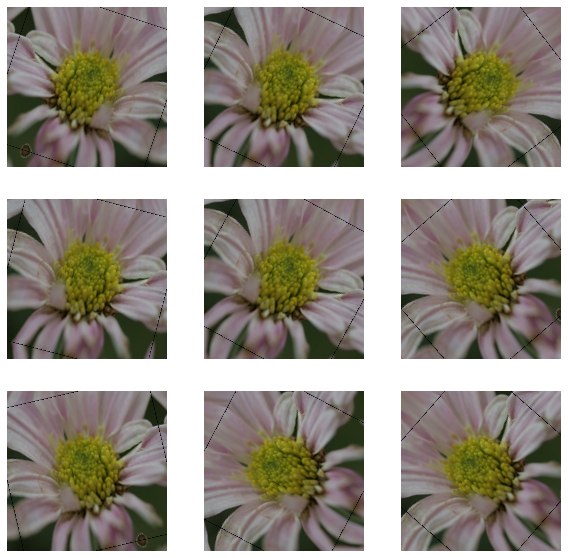

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [9]:
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(160, 160)
(160, 160, 3)


In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(256, 5, 5, 512)


In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(256, 512)


In [13]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(256, 5)


In [14]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)              

In [17]:
len(model.trainable_variables)

28

In [18]:
history_fine = model.fit(train_dataset,
                         epochs=150,
                         validation_data=validation_dataset)

Epoch 1/150
12/12 [==============================] - 14s 1s/step - loss: 2.1450 - accuracy: 0.3559 - val_loss: 1.1172 - val_accuracy: 0.5654
Epoch 2/150
12/12 [==============================] - 10s 849ms/step - loss: 1.0716 - accuracy: 0.5698 - val_loss: 0.9305 - val_accuracy: 0.6117
Epoch 3/150
12/12 [==============================] - 10s 842ms/step - loss: 0.9250 - accuracy: 0.6298 - val_loss: 0.7608 - val_accuracy: 0.7153
Epoch 4/150
12/12 [==============================] - 10s 843ms/step - loss: 0.8203 - accuracy: 0.6877 - val_loss: 0.6105 - val_accuracy: 0.7616
Epoch 5/150
12/12 [==============================] - 10s 846ms/step - loss: 0.6306 - accuracy: 0.7650 - val_loss: 0.5334 - val_accuracy: 0.8147
Epoch 6/150
12/12 [==============================] - 10s 846ms/step - loss: 0.5593 - accuracy: 0.7980 - val_loss: 0.4418 - val_accuracy: 0.8406
Epoch 7/150
12/12 [==============================] - 10s 846ms/step - loss: 0.5122 - accuracy: 0.8154 - val_loss: 0.4582 - val_accuracy: 0.

Epoch 56/150
12/12 [==============================] - 10s 858ms/step - loss: 0.0250 - accuracy: 0.9891 - val_loss: 0.4115 - val_accuracy: 0.9005
Epoch 57/150
12/12 [==============================] - 10s 856ms/step - loss: 0.0260 - accuracy: 0.9932 - val_loss: 0.3465 - val_accuracy: 0.9196
Epoch 58/150
12/12 [==============================] - 10s 851ms/step - loss: 0.0237 - accuracy: 0.9908 - val_loss: 0.3651 - val_accuracy: 0.9210
Epoch 59/150
12/12 [==============================] - 10s 855ms/step - loss: 0.0197 - accuracy: 0.9922 - val_loss: 0.4117 - val_accuracy: 0.9019
Epoch 60/150
12/12 [==============================] - 10s 859ms/step - loss: 0.0117 - accuracy: 0.9973 - val_loss: 0.5075 - val_accuracy: 0.9142
Epoch 61/150
12/12 [==============================] - 10s 855ms/step - loss: 0.0239 - accuracy: 0.9932 - val_loss: 0.4000 - val_accuracy: 0.9114
Epoch 62/150
12/12 [==============================] - 10s 852ms/step - loss: 0.0765 - accuracy: 0.9755 - val_loss: 0.3249 - val_ac

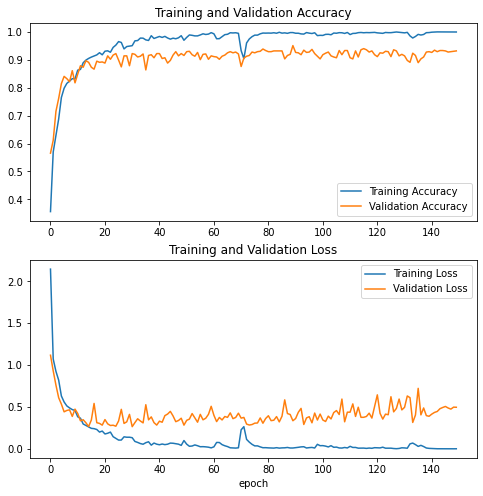

In [20]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
